In [2]:
# set the cwd to the root of the repo
import os
os.chdir("/workspaces/sdfstudio/")

import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.models.reni_neus import RENINeuSModel, RENINeuSModelConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames

In [3]:
# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

ckpt_path = 'outputs/data-NeRF-OSR-Data/RENI-NeuS/2023-03-09_132447'
step = 40000

ckpt = torch.load(ckpt_path + '/sdfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        model_dict[key[7:]] = ckpt['pipeline'][key]

config = method_configs["RENI-NeuS"]

# ckpt_config = cfg.InstantiateConfig(yaml.load(ckpt_path + '/config.yml', Loader=yaml.Loader)).setup()


In [4]:
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

config = method_configs["RENI-NeuS"]

pipeline_config = config.pipeline
pipeline_config.datamanager.dataparser.scene = 'lk2'
pipeline_config.datamanager.dataparser.use_session_data = False

# config = # vaninllanpipelineconfig / fit_eval_pipeline_config
datamanager: VanillaDataManager = pipeline_config.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)
# includes num_eval_data as needed for reni latent code fitting.
model = pipeline_config.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    num_eval_data=len(datamanager.eval_dataset),
    metadata=datamanager.train_dataset.metadata,
    world_size=world_size,
    local_rank=local_rank,
    eval_latent_optimisation_source=pipeline_config.eval_latent_optimisation_source,
)
model.to(device)

Loading data batch ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

RENINeuSModel(
  (collider): NearFarCollider()
  (scene_contraction): SceneContraction()
  (field): SDFAlbedoVisibilityField(
    (spatial_distortion): SceneContraction()
    (encoding): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float16, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Smoothstep', 'log2_hashmap_size': 19, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.3819128274917603, 'type': 'Hash'})
    (position_encoding): NeRFEncoding()
    (direction_encoding): NeRFEncoding()
    (glin0): Linear(in_features=71, out_features=256, bias=True)
    (glin1): Linear(in_features=256, out_features=256, bias=True)
    (glin2): Linear(in_features=256, out_features=256, bias=True)
    (glin3): Linear(in_features=256, out_features=185, bias=True)
    (glin4): Linear(in_features=256, out_features=256, bias=True)
    (glin5): Linear(in_features=256, out_features=257, bias=True)
    (laplace_density): Laplac

In [5]:
ckpt_path = 'outputs/data-NeRF-OSR-Data/RENI-NeuS/2023-03-09_132447/sdfstudio_models/step-000040000.ckpt'
ckpt = torch.load(ckpt_path, map_location=device)
model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        model_dict[key[7:]] = ckpt['pipeline'][key]

model.load_state_dict(model_dict)

<All keys matched successfully>

In [81]:
image_idx, camera_ray_bundle, batch = datamanager.next_eval_image(1)
img = batch['image'] # [H, W, 3]
fg_mask = batch['fg_mask'].images[0] # [H, W]
fg_mask = fg_mask.reshape(-1).bool() # [H*W]

In [82]:
origins = camera_ray_bundle.origins # [H, W, 1, 3]
directions = camera_ray_bundle.directions # [H, W, 1, 3]
pixel_area = camera_ray_bundle.pixel_area # [H, W, 1, 1]
directions_norm = camera_ray_bundle.directions_norm # [H, W, 1, 1]
camera_indices = camera_ray_bundle.camera_indices # [H, W, 1, 1]

In [83]:
# flatten
origins = origins.reshape(-1, 3) # [H*W, 3]
directions = directions.reshape(-1, 3) # [H*W, 3]
pixel_area = pixel_area.reshape(-1, 1) # [H*W, 1]
directions_norm = directions_norm.reshape(-1, 1) # [H*W, 1]
camera_indices = camera_indices.reshape(-1, 1) # [H*W, 1]
# set all nears to 0.05
nears = torch.zeros_like(directions_norm) + 0.05
# set all fars to 100
fars = torch.zeros_like(directions_norm) + 100

# mask and update camera ray bundle
camera_ray_bundle.origins = origins[fg_mask]
camera_ray_bundle.directions = directions[fg_mask]
camera_ray_bundle.pixel_area = pixel_area[fg_mask]
camera_ray_bundle.directions_norm = directions_norm[fg_mask]
camera_ray_bundle.camera_indices = camera_indices[fg_mask]
camera_ray_bundle.nears = nears[fg_mask]
camera_ray_bundle.fars = fars[fg_mask]

In [90]:
# generate sample
indices = random.sample(range(len(camera_ray_bundle)), k=256)

In [91]:
camera_ray_bundle.origins = camera_ray_bundle.origins[indices]
camera_ray_bundle.directions = camera_ray_bundle.directions[indices]
camera_ray_bundle.pixel_area = camera_ray_bundle.pixel_area[indices]
camera_ray_bundle.directions_norm = camera_ray_bundle.directions_norm[indices]
camera_ray_bundle.camera_indices = camera_ray_bundle.camera_indices[indices]
camera_ray_bundle.nears = camera_ray_bundle.nears[indices]
camera_ray_bundle.fars = camera_ray_bundle.fars[indices]

In [92]:
# forward through model for camera ray bundle
ray_samples, weights_list, ray_samples_list = model.proposal_sampler(camera_ray_bundle, density_fns=model.density_fns)

# Get camera indices for each sample for use in the illumination field
camera_indices = ray_samples.camera_indices.squeeze()  # [num_rays, samples_per_ray]

illumination_field = model.illumination_field_train

illumination_directions = model.illumination_sampler(model.config.num_illumination_samples)
illumination_directions = illumination_directions.to(device)

field_outputs = model.field(ray_samples, return_alphas=True, illumination_directions=illumination_directions)
weights, transmittance = ray_samples.get_weights_and_transmittance_from_alphas(
    field_outputs[FieldHeadNames.ALPHA]
)

bg_transmittance = transmittance[:, -1, :]

weights_list.append(weights)
ray_samples_list.append(ray_samples)

p2p_dist = model.renderer_depth(weights=weights, ray_samples=ray_samples)
# convert point-to-point distance to depth
depth = p2p_dist / camera_ray_bundle.directions_norm

In [93]:
origins = camera_ray_bundle.origins + camera_ray_bundle.directions * p2p_dist

In [94]:
sdf = model.field.get_sdf_at_pos(origins)

In [97]:
# plot histogram of sdf
# remove sdf value over 2
sdf = sdf[sdf < 2]
# standard deviation
sdf.std()

tensor(0.0332, device='cuda:0', grad_fn=<StdBackward0>)

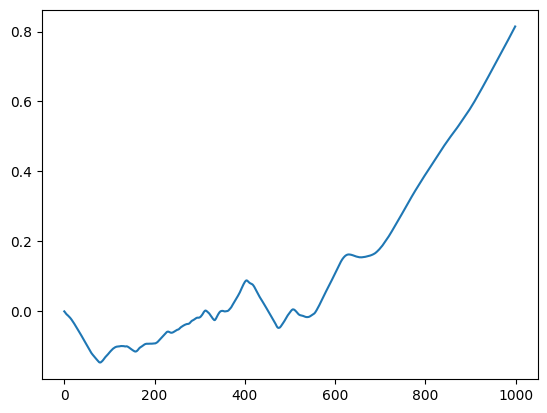

In [115]:
# choose a single origin, gradually travel along the ray direction and plot the sdf value
origin = origins[0].repeat(1000, 1)
direction = camera_ray_bundle.directions[0].repeat(1000, 1)
termination = p2p_dist[0].item() + 2.0
# sample 100 points along the ray
dist = torch.linspace(0, termination, 1000).unsqueeze(1).to(device)
# get sdf value at each point
sdf = model.field.get_sdf_at_pos(origin + direction * dist)
# plot
# convert to numpy and plot
sdf = sdf.cpu().detach().numpy()
plt.plot(sdf)

In [105]:
origin + direction * dist

RuntimeError: The size of tensor a (3) must match the size of tensor b (100) at non-singleton dimension 1

In [33]:
# plot origins using plotly
# remove any points in origins with a y greater than 7
origins = origins[origins[:, 1] < 7]
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(
    x=origins[:, 0].cpu().detach().numpy(),
    y=origins[:, 1].cpu().detach().numpy(),
    z=origins[:, 2].cpu().detach().numpy(),
    mode='markers',
)])
fig.show()

In [39]:
origins.max()

tensor(1.1899, device='cuda:0', grad_fn=<MaxBackward1>)

In [40]:
sdf.min()

tensor(-0.1311, device='cuda:0', grad_fn=<MinBackward1>)

In [41]:
sdf.mean()

tensor(0.0238, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
sdf.max()

tensor(6.7890, device='cuda:0', grad_fn=<MaxBackward1>)